# Packages to Install

In [1]:
#!pip install opencv-python
#!pip install scipy
#!pip install tensorflow-addons
#!pip install pydot    

# All Imports 


In [4]:
import numpy as np
import tensorflow as tf
import os
import sys
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input,Dropout,Conv2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


In [5]:
print("No. of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

No. of GPUs Available:  1


#  Data paths


In [6]:
#data and model paths 
oTrainDataPath = "C:\\Users\\SWONG\\PRS_project\\Border_data\\train\\"
oValDataPath = "C:\\Users\\SWONG\\PRS_project\\Border_data\\val\\"
#directory to which the trained checkpoints are saved
oModelPath = "C:\\Users\\SWONG\\PRS_project\\Model\\"

# Data Generator

In [7]:
#create training Image Generator
oTrainGen = ImageDataGenerator( samplewise_std_normalization=False,
                               samplewise_center=False,
                               rotation_range=45,zoom_range=0.5,
                               width_shift_range=0.2,height_shift_range=0.2,
                               brightness_range = [0.7, 1.3],
                               shear_range=0.15,horizontal_flip=True,
                               vertical_flip=True,fill_mode="nearest",
                              )
#create validation Image Generator
oValGen = ImageDataGenerator( samplewise_std_normalization=False,
                               samplewise_center=False,
                               rotation_range=0,zoom_range=0,
                               width_shift_range=0.0,height_shift_range=0.0,
                               shear_range=0.0,horizontal_flip=False,
                               vertical_flip=False,fill_mode="nearest",
                              )


#read training data batch by batch
oTrainingGenerator = oTrainGen.flow_from_directory(directory=oTrainDataPath,
                                                   target_size=(224, 224),
                                                   color_mode="rgb",
                                                   batch_size=16,
                                                   class_mode="binary",
                                                   shuffle=True,
                                                   seed=42
                                                   )
#read validation data batch by batch
oValGenerator = oValGen.flow_from_directory(directory=oValDataPath,
                                                   target_size=(224, 224),
                                                   color_mode="rgb",
                                                   batch_size=16,
                                                   class_mode="binary",
                                                   shuffle=True,
                                                   seed=42
                                                   )


Found 8111 images belonging to 2 classes.
Found 902 images belonging to 2 classes.


# Load Pretrained Model

In [8]:
# create the base pre-trained model
#specify which pretrained model should be loaded 
oFlag = "DenseNet121"
input_tensor = Input(shape=(224, 224, 3),dtype = tf.uint8)

if oFlag ==  "InceptionV3":    
    base_model = InceptionV3(input_tensor=input_tensor,weights='imagenet', include_top=False)
elif oFlag ==  "ResNet50V2":
    base_model = ResNet50V2(input_tensor=input_tensor,weights='imagenet', include_top=False)
elif oFlag ==  "MobileNetV2":
    x = tf.cast(input_tensor, tf.float32)
    x = tf.keras.applications.mobilenet.preprocess_input(x)
    base_model = MobileNetV2(input_tensor=x,weights='imagenet', include_top=False)
elif oFlag ==  "DenseNet121":
    x = tf.cast(input_tensor, tf.float32)
    x = tf.keras.applications.densenet.preprocess_input(x)
    base_model = DenseNet121(input_tensor=x,weights='imagenet', include_top=False)
elif oFlag ==  "EfficientNetB0":
    base_model = EfficientNetB0(input_tensor=input_tensor,weights='imagenet', include_top=False)
elif oFlag ==  "EfficientNetB3":
    base_model = EfficientNetB3(input_tensor=input_tensor,weights='imagenet', include_top=False)


# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
#add a fully-connected layer and the output layer
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
prediction = Dense(1, activation='sigmoid')(x)

# create the model
model = Model(inputs=input_tensor, outputs=prediction)

#Add Regularizer to conv and dense layers
alpha = 1e-4
for layer in model.layers:
    if isinstance(layer,Conv2D) or isinstance(layer,Dense):
        layer.add_loss(lambda: regularizers.l2(alpha)(layer.kernel))
    #if hasattr(layer,'bias_regularizer') and layer.use_bias:
    #    layer.add_loss(lambda: regularizers.l2(alpha)(layer.bias))
        

model.summary()

#compile the model
oFocalLoss = tfa.losses.SigmoidFocalCrossEntropy(reduction=tf.keras.losses.Reduction.AUTO)
model.compile(optimizer=Adam(lr=0.0001), loss = "binary_crossentropy",metrics = ['accuracy'])


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 224, 224, 3)  0           tf.cast[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 224, 224, 3)  0           tf.math.truediv[0][0]            
______________________________________________________________________________________________

C:\Users\SWONG\anaconda3\envs\gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


# Callbacks

In [9]:
# Create a callback that saves the model's weights
checkpoint_path = os.path.join(oModelPath,oFlag + ".hdf5")
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor ='val_loss',  
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 verbose=1)
#create callbacks for monitoring training
tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1)

csv_logger      = CSVLogger(os.path.join(oModelPath,oFlag+'.csv'))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

#create callback for reducing learning rate
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, mode = 'min',min_lr=0.000005)

callbacks=[cp_callback,tb_callback,csv_logger,early_stopping]

# Fit Model

In [10]:
STEP_SIZE_TRAIN=oTrainingGenerator.n//oTrainingGenerator.batch_size
STEP_SIZE_VALID=oValGenerator.n//oValGenerator.batch_size

#class weights
class_weight = {0:6, 1:1}

model.fit(x=oTrainingGenerator, 
          y=None, 
          batch_size=16, 
          epochs=100, 
          verbose=1, 
          callbacks=callbacks, 
          validation_data=oValGenerator,
          shuffle=True,
          steps_per_epoch=STEP_SIZE_TRAIN,
          class_weight = class_weight,
          validation_steps=STEP_SIZE_VALID,
          validation_batch_size=16)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
506/506 [==============================] - 251s 467ms/step - loss: 0.9841 - accuracy: 0.6812 - val_loss: 0.4299 - val_accuracy: 0.7734

Epoch 00001: val_loss improved from inf to 0.42990, saving model to C:\Users\SWONG\PRS_project\Model\DenseNet121.hdf5
Epoch 2/100
506/506 [==============================] - 240s 474ms/step - loss: 0.8986 - accuracy: 0.7214 - val_loss: 0.5961 - val_accuracy: 0.6607

Epoch 00002: val_loss did not improve from 0.42990
Epoch 3/100
506/506 [==============================] - 251s 495ms/step - loss: 0.8787 - accuracy: 0.7305 - val_loss: 0.5569 - val_accuracy: 0.7400

Epoch 00003: val_loss did not improve from 0.42990
Epoch 4/100
506/506 [==============================] - 248s 489ms/step - loss: 0.8633 - accuracy: 0.7329 - val_loss: 0.5297 - val_accuracy: 0.7087

Epoch 00004: val_loss did not improve from 0.42990

506/506 [==============================] - 248s 490ms/step - loss: 0.7398 - accuracy: 0.7633 - val_loss: 0.4692 - val_accuracy: 0.7600

Epoch 00039: val_loss did not improve from 0.31323
Epoch 40/100
506/506 [==============================] - 249s 491ms/step - loss: 0.7403 - accuracy: 0.7534 - val_loss: 0.3931 - val_accuracy: 0.8013

Epoch 00040: val_loss did not improve from 0.31323
Epoch 41/100
506/506 [==============================] - 248s 490ms/step - loss: 0.7333 - accuracy: 0.7540 - val_loss: 0.3311 - val_accuracy: 0.8415

Epoch 00041: val_loss did not improve from 0.31323
Epoch 42/100
506/506 [==============================] - 248s 490ms/step - loss: 0.7450 - accuracy: 0.7569 - val_loss: 0.3587 - val_accuracy: 0.8382

Epoch 00042: val_loss did not improve from 0.31323
Epoch 43/100
506/506 [==============================] - 249s 493ms/step - loss: 0.7102 - accuracy: 0.7731 - val_loss: 0.3752 - val_accuracy: 0.8136

Epoch 00043: val_loss did not improve from 0.31323
Epoch 44/100


506/506 [==============================] - 241s 477ms/step - loss: 0.6942 - accuracy: 0.7790 - val_loss: 0.3687 - val_accuracy: 0.8147

Epoch 00079: val_loss did not improve from 0.29878
Epoch 80/100
506/506 [==============================] - 243s 481ms/step - loss: 0.6773 - accuracy: 0.7837 - val_loss: 0.4133 - val_accuracy: 0.7868

Epoch 00080: val_loss did not improve from 0.29878
Epoch 81/100
506/506 [==============================] - 243s 480ms/step - loss: 0.6896 - accuracy: 0.7831 - val_loss: 0.4601 - val_accuracy: 0.7734

Epoch 00081: val_loss did not improve from 0.29878
Epoch 82/100
506/506 [==============================] - 242s 478ms/step - loss: 0.6898 - accuracy: 0.7743 - val_loss: 0.3392 - val_accuracy: 0.8371

Epoch 00082: val_loss did not improve from 0.29878
Epoch 83/100
506/506 [==============================] - 240s 473ms/step - loss: 0.6736 - accuracy: 0.7875 - val_loss: 0.4312 - val_accuracy: 0.7879

Epoch 00083: val_loss did not improve from 0.29878
Epoch 84/100


# Plot curves on validation loss and accuracy

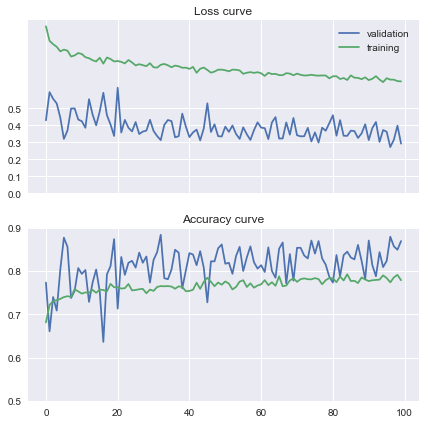

In [11]:
plt.style.use('seaborn')                   # if want to use the default style, set 'classic'
plt.rcParams['ytick.right']     = True
plt.rcParams['ytick.labelright']= False
plt.rcParams['ytick.left']      = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['figure.figsize']  = [7,7]   # Set the figure size to be 7 inch for (width,height)

records     = pd.read_csv(os.path.join(oModelPath,oFlag+'.csv'))
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'], label="validation")
plt.plot(records['loss'],label="training")
plt.yticks([0.00,0.1,0.2,0.3,0.4,0.50])
plt.title('Loss curve',fontsize=12)

ax          = plt.gca()
ax.set_xticklabels([])

plt.subplot(212)
plt.plot(records['val_accuracy'],label="validation")
plt.plot(records['accuracy'],label="training")
plt.yticks([0.5,0.6,0.7,0.8,0.9])
plt.title('Accuracy curve',fontsize=12)
ax.legend()
#save the plot
plotpath  = os.path.join(oModelPath,oFlag + '_plot.png')
plt.savefig(plotpath)
#Display
plt.show()

#  Save the model plot


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Path to plot: D:\PRS_project\Model\MobileNetV2_plot.png
